## Семинар 7: "Методы оптимизации"

ФИО: Яковлев Дмитрий Алексеевич

In [3]:
from functools import partial

import numpy as np

import torch
from torch import nn
from torchvision import datasets, transforms

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

from matplotlib import cm
from matplotlib import animation

from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec

from mpl_toolkits import mplot3d

from IPython.display import HTML

%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, RMSProp, Adadelta, Adam.

### Часть 1: Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [4]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):   
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)
    
    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

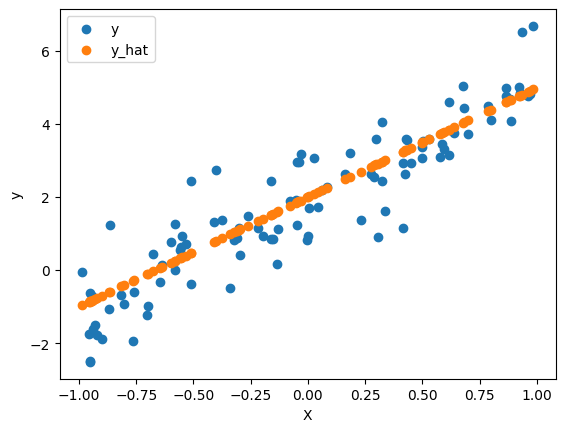

In [5]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

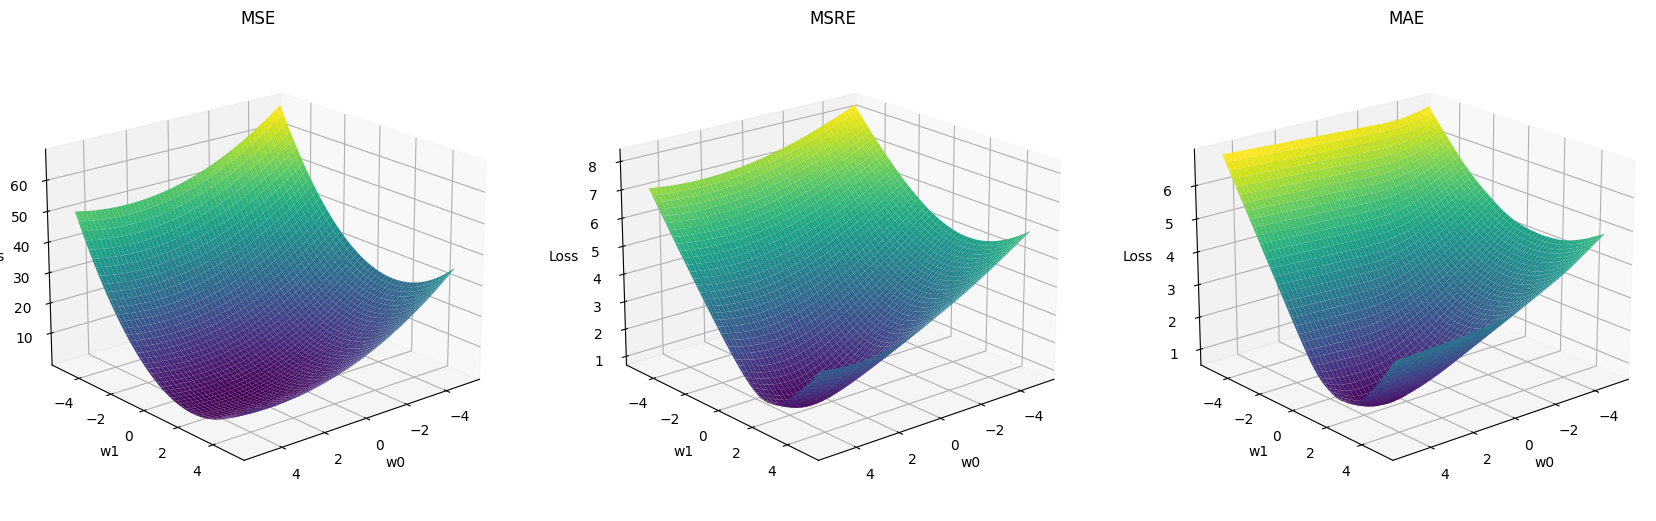

In [6]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

<i> 1.1 Реализуйте методы SGD, Momentum, NAG, Adagrad, Adadelta, Adam.</i> **(1 балл)**

In [7]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()
    
    def pre_step(self):
        pass
    
    def step(self):
        pass
    
    def update_param(self, p, delta):
        p.data.add_(delta)

In [8]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [9]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }
    
    return loss_animator.animate(num_iter, data, step_skip=step_skip)

##### Оптимизаторы

In [10]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad


class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, momentum=0.9):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        self.velocities = [torch.zeros_like(p.data) for p in self.params]
    
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                grad = p.grad.data
                self.velocities[i] = self.momentum * self.velocities[i] + (1 - self.momentum) * grad
                p.data -= self.lr * self.velocities[i]


class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, momentum=0.9):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        self.velocities = [torch.zeros_like(p.data) for p in self.params]
    
    def pre_step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.velocities[i] = self.momentum * self.velocities[i]
                p.data -= self.lr * self.velocities[i]
    
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                p.data += self.momentum * self.momentum * self.velocities[i]
                p.data -= (1 + self.momentum) * self.lr * p.grad.data
                self.velocities[i] = self.momentum * self.velocities[i] - self.lr * p.grad.data


class Adadelta(Optimizer):
    def __init__(self, params, lr=1e-1, rho=0.9, eps=1e-8):
        super().__init__(params)
        self.rho = rho
        self.eps = eps
        self.lr = lr
        self.acc_grads = [torch.zeros_like(p) for p in self.params]
        self.acc_deltas = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                acc_grad = self.acc_grads[i]
                acc_delta = self.acc_deltas[i]
                acc_grad.mul_(self.rho).addcmul_(p.grad, p.grad, value=1 - self.rho)
                std = acc_delta.add(self.eps).sqrt().div_(acc_grad.add(self.eps).sqrt())
                delta = p.grad.mul(std)
                acc_delta.mul_(self.rho).addcmul_(delta, delta, value=1 - self.rho)
                self.update_param(p, -self.lr*delta)


class Adagrad(Optimizer):
    def __init__(self, params, lr=1e-1, eps=1e-8):
        super().__init__(params)
        self.lr = lr
        self.eps = eps
        self.acc_gradients = [torch.zeros_like(p.data) for p in self.params]
        
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.acc_gradients[i].data += p.grad.pow(2)
                self.update_param(p, -self.lr * p.grad.data / (self.acc_gradients[i].sqrt() + self.eps))


class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.99, eps=1e-08):
        super().__init__(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
                self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad) ** 2
                self.update_param(p, -self.lr * self.m[i] / (torch.sqrt(self.v[i]) + self.eps))

<i1> 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [11]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ('SGD', SGD, {'lr': 1e-1}),
        ('Momentum', Momentum, {'lr': 1e-1}),
        ('NAG', NAG, {'lr': 1e-1}),
        ('Adadelta', Adadelta, {'lr': 1e-1}),
        ('Adagrad', Adagrad, {'lr': 1e-1}),
        ('Adam', Adam, {'lr': 1e-1})
    ],
    [-5, -5],
    num_iter = 100,
    step_skip = 1
)

/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


In [12]:
compare_optimizers(
    loss_animator,
    mae,
    [
        ('SGD', SGD, {'lr': 1e-1}),
        ('Momentum', Momentum, {'lr': 1e-1}),
        ('NAG', NAG, {'lr': 1e-1}),
        ('Adadelta', Adadelta, {'lr': 1e-1}),
        ('Adagrad', Adagrad, {'lr': 1e-1}),
        ('Adam', Adam, {'lr': 1e-1})
    ],
    [-5, -5],
    num_iter = 100,
    step_skip = 1
)

/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


In [13]:
compare_optimizers(
    loss_animator,
    msre,
    [
        ('SGD', SGD, {'lr': 1e-1}),
        ('Momentum', Momentum, {'lr': 1e-1}),
        ('NAG', NAG, {'lr': 1e-1}),
        ('Adadelta', Adadelta, {'lr': 1e-1}),
        ('Adagrad', Adagrad, {'lr': 1e-1}),
        ('Adam', Adam, {'lr': 1e-1})
    ],
    [-5, -5],
    num_iter = 100,
    step_skip = 1
)

/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([xs, ys, zs, np.ones_like(xs)])


#### Выводы
При $10^{-1}$ $learning\ rate$, за 100 шагов<br>
Хорошо сходятся вне зависимости от функции потерь:
- NAG - градиент с ускорением Нестерова
- ADAM - адаптивный предсказатель моментов

Далее не сильно хуже справляется классический SGD и Momentum, в своей сути SGD с ускорением.

Хуже всего справляются Adadelta и Adagrad, думаю это связано с тем, что оптимизация ими требует более детальной настройки, а также для функций потерь, которые мы здесь пытаемся оптимизировать, данные методы избыточны.

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i> **(2 балла)**

In [14]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2023-06-10 20:12:15--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2023-06-10 20:12:15--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [           <=>      ]  33.20M  15.0MB/s    in 2.2s    

2023-06-10 20:12:18 (15.0 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [15]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Возьмём трейн функцию из прошлой тетради и будем передавать в неё в качестве параметра оптимизатор.

In [19]:
from IPython.display import clear_output

In [20]:
def train(network, optim, epochs=5, learning_rate=1e-4):
    loss = nn.NLLLoss()
    optimizer = optim(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

##### **Dense experiments**

In [17]:
class DenseClassifier(nn.Module):
    def __init__(self, image_size):
        super(DenseClassifier, self).__init__()

        self.linear_layers = nn.Sequential(
            nn.Linear(image_size**2, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

###### ***Adam***


Epoch 4... (Train/Test) NLL: 0.135/0.135	Accuracy: 0.960/0.961


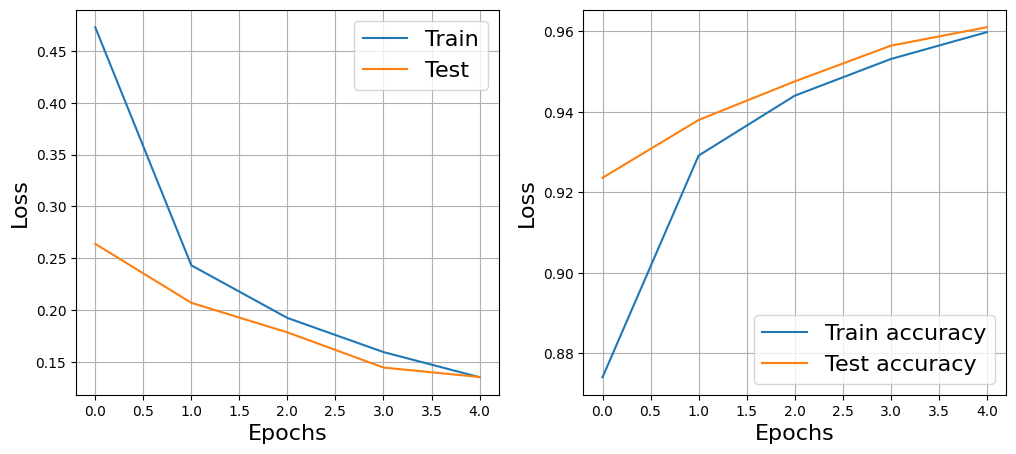

In [22]:
train(DenseClassifier(28), Adam, learning_rate=1e-4)

**Adam dense:**
* $learning\ rate = 10^{-4}$
* Сходиться монотонно в среднем по эпохе
* $score = 0.960/0.961\ (train/test)$
* $loss = 0.135/0.135\ (train/test)$


###### ***Adagrad***

Epoch 4... (Train/Test) NLL: 0.271/0.258	Accuracy: 0.922/0.926


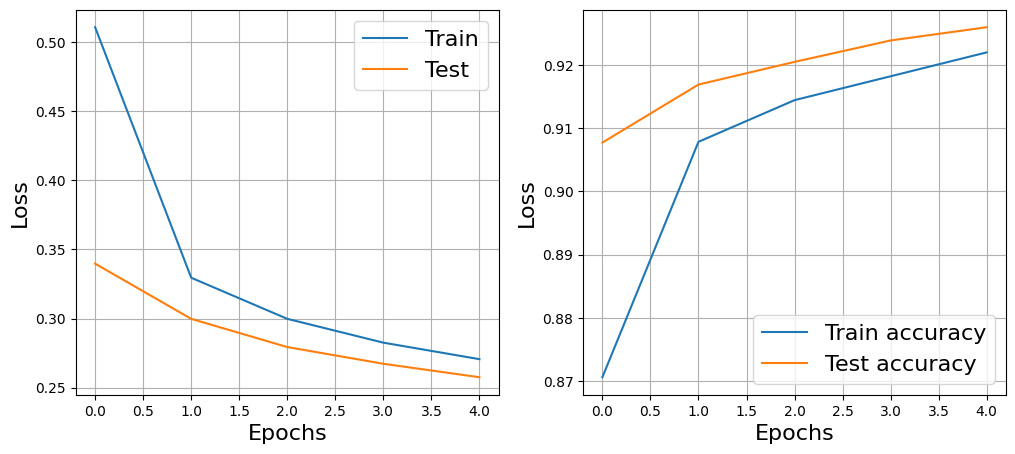

In [38]:
train(DenseClassifier(28), Adagrad, learning_rate=1e-3)

**Adagrad dense:**
* $learning\ rate = 10^{-3}$
* Сходиться монотонно в среднем по эпохе
* $score = 0.922/0.926\ (train/test)$
* $loss = 0.271/0.258\ (train/test)$

###### ***Adadelta***

Epoch 4... (Train/Test) NLL: 0.084/0.093	Accuracy: 0.975/0.971


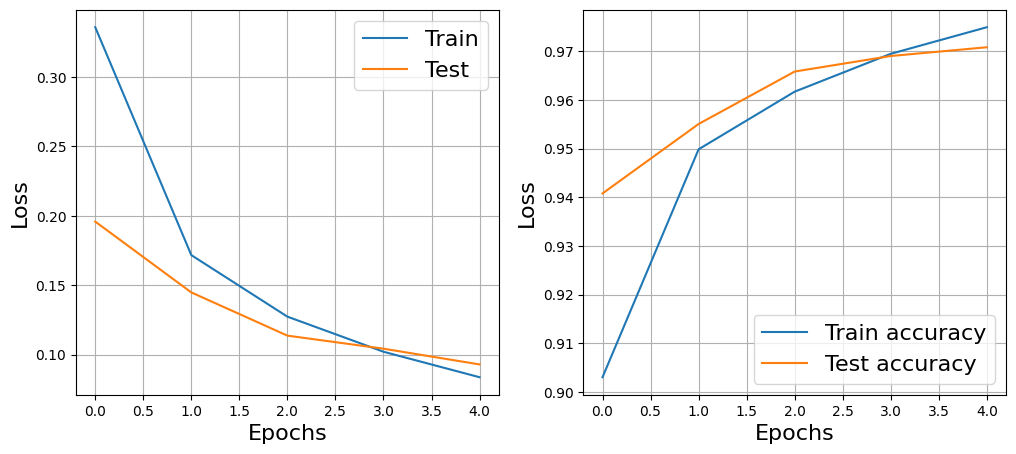

In [33]:
train(DenseClassifier(28), Adadelta, learning_rate=1e0)

**Adadelta dense:**
* $learning\ rate = 1$
* Сходиться монотонно в среднем по эпохе
* $score = 0.975/0.971\ (train/test)$
* $loss = 0.084/0.093\ (train/test)$

###### ***SGD***

Epoch 4... (Train/Test) NLL: 0.041/0.076	Accuracy: 0.986/0.980


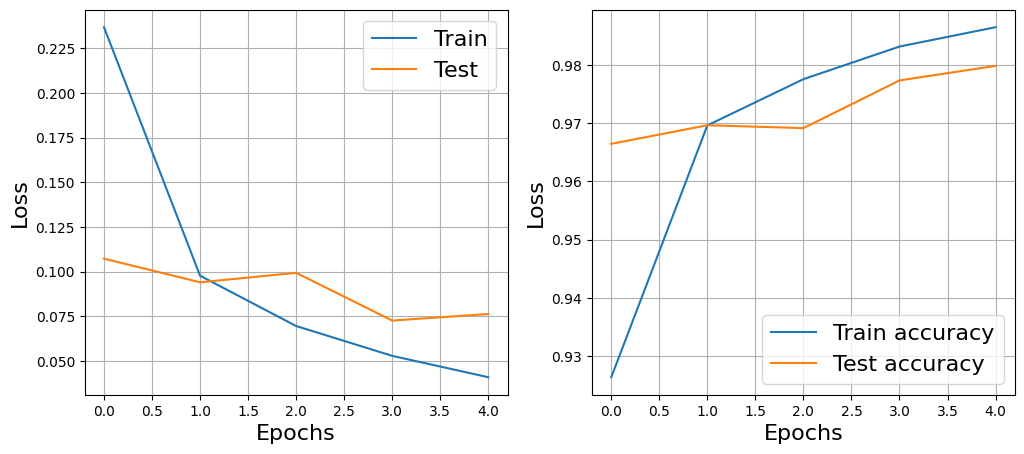

In [32]:
train(DenseClassifier(28), SGD, learning_rate=1e-1)

**SGD dense:**
* $learning\ rate = 10^{-1}$
* Сходиться монотонно в среднем по эпохе, test - нет
* $score = 0.986/0.980\ (train/test)$
* $loss = 0.041/0.076\ (train/test)$

###### **Выводы**

* Наибольший $score_{train} = 0.986 ⇒ SGD$ 
* Наибольший $score_{test} = 0.980 ⇒ SGD$
* Наименьший $| score_{train} - score_{test} | = 0.001 ⇒ Adam$
* Наименьший $loss_{train} = 0.041 ⇒ SGD$
* Наименьший $loss_{test} = 0.076 ⇒ SGD$
* Наименьший $| loss_{train} - loss_{test} | = 0 ⇒ Adam$ 

##### **Convolution experiments**

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i> **(1 балл)**

In [26]:
class ConvClassifier(nn.Module):
    def __init__(self, image_size, channels):
        super(ConvClassifier, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(channels, 8, 3), 
            nn.ReLU(), 
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, 3), 
            nn.ReLU()
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(
                int(((image_size - 3 + 1)/2 - 3 + 1)**2 * 16), 
                10
            ), 
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

###### ***Adam***


Epoch 4... (Train/Test) NLL: 0.071/0.067	Accuracy: 0.979/0.980


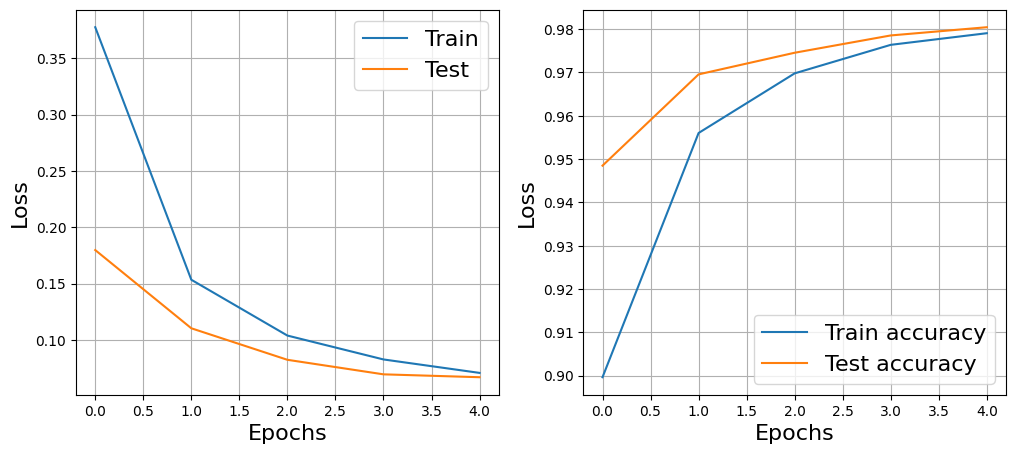

In [27]:
train(ConvClassifier(28, 1), Adam, learning_rate=1e-4)

**Adam conv:**
* $learning\ rate = 10^{-4}$
* Сходиться монотонно в среднем по эпохе
* $score = 0.979/0.980\ (train/test)$
* $loss = 0.071/0.067\ (train/test)$

###### ***Adagrad***

Epoch 4... (Train/Test) NLL: 0.216/0.200	Accuracy: 0.938/0.946


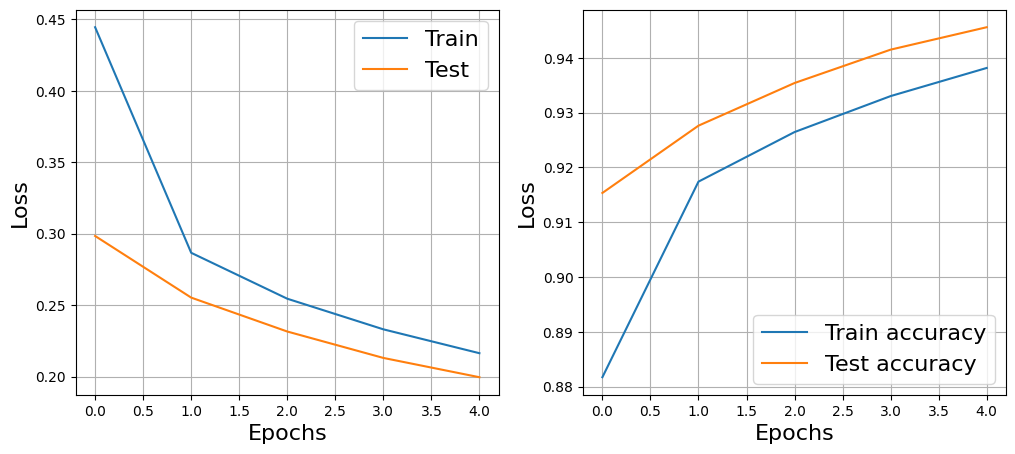

In [39]:
train(ConvClassifier(28, 1), Adagrad, learning_rate=1e-3)

**Adagrad conv:**
* $learning\ rate = 10^{-3}$
* Сходиться монотонно в среднем по эпохе
* $score = 0.938/0.946\ (train/test)$
* $loss = 0.216/0.200\ (train/test)$

###### ***Adadelta***

Epoch 4... (Train/Test) NLL: 0.062/0.050	Accuracy: 0.981/0.984


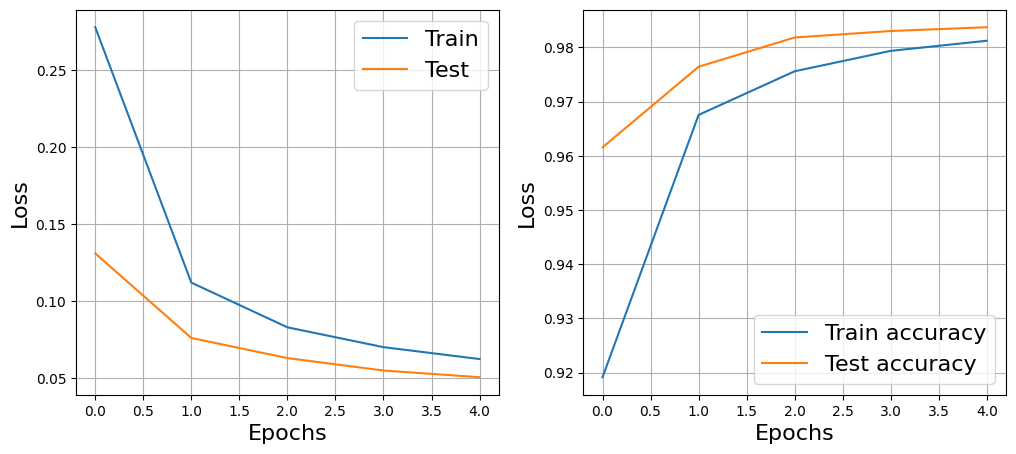

In [34]:
train(ConvClassifier(28, 1), Adadelta, learning_rate=1e0)

**Adadelta conv:**
* $learning\ rate = 1$
* Сходиться монотонно в среднем по эпохе
* $score = 0.981/0.984\ (train/test)$
* $loss = 0.062/0.050\ (train/test)$

###### ***SGD***

Epoch 4... (Train/Test) NLL: 0.029/0.036	Accuracy: 0.991/0.988


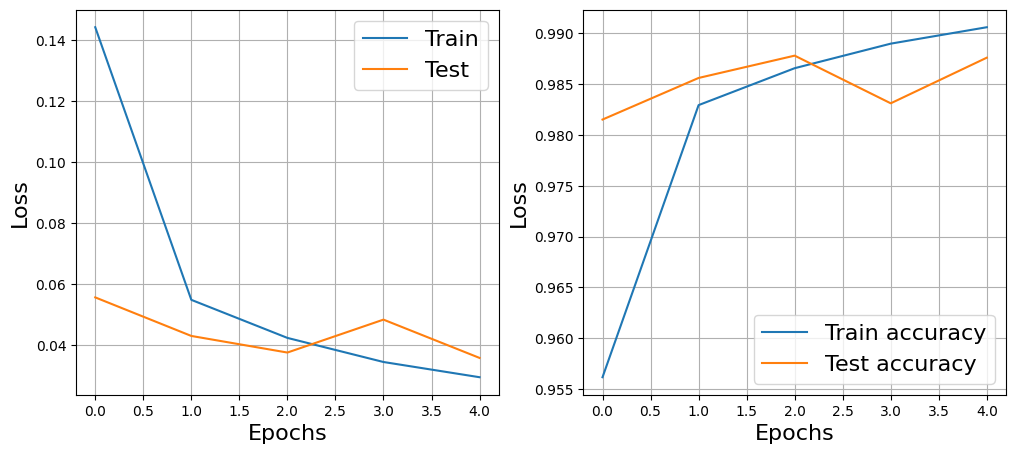

In [35]:
train(ConvClassifier(28, 1), SGD, learning_rate=1e-1)

**SGD conv:**
* $learning\ rate = 10^{-1}$
* Сходиться монотонно в среднем по эпохе, test - нет
* $score = 0.991/0.988\ (train/test)$
* $loss = 0.029/0.036\ (train/test)$

###### **Выводы**

* Наибольший $score_{train} = 0.991 ⇒ SGD$ 
* Наибольший $score_{test} = 0.988 ⇒ SGD$
* Наименьший $| score_{train} - score_{test} | = 0.001 ⇒ Adam$
* Наименьший $loss_{train} = 0.029 ⇒ SGD$
* Наименьший $loss_{test} = 0.036 ⇒ SGD$
* Наименьший $| loss_{train} - loss_{test} | = 0.004 ⇒ Adam$ 

##### **Выводы по Adam, Adagrad, Adadelta, SGD**

Лучше всего продемонстрировали себя SGD и Adam
* Не требуют усердно подбирать $learning\ rate$
* Adam лучше всех не переобучает, как Dense так и на Conv модель
* SGD быстрее всех сходится, в конкретном случае это можно объяснить тем, что более сложные оптимизаторы для MNIST задачи избыточны, и способны хорошо себя проявлять на специфичных задачах.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: